In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score

In [5]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(72, (3, 3),  kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(72, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = Dropout(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(144, (3, 3),  kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(144, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = Dropout(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(288, (3, 3),  kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(288, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = Dropout(0.2)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(576, (3, 3),  kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(576, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = Dropout(0.2)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(1152, (3, 3),  kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1152, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = Dropout(0.3)(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)

    b1 = Conv2D(2304, (3, 3),  kernel_initializer='he_normal', padding='same')(p5) 
    b1 = BatchNormalization()(b1)
    b1 = Conv2D(2304, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b1) 
    b1 = Dropout(0.3)(b1)
    
    #Expansive path 
    u7 = Conv2DTranspose(1152, (2, 2), strides=(2, 2), padding='same')(b1)
    u7 = concatenate([u7, c5])
    c6 = Conv2D(1152, (3, 3),  kernel_initializer='he_normal', padding='same')(u7)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(1152, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = Dropout(0.2)(c6)
    
    u6 = Conv2DTranspose(576, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(576, (3, 3),  kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(576, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = Dropout(0.2)(c6)
     
    u7 = Conv2DTranspose(288, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(288, (3, 3),  kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(288, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = Dropout(0.2)(c7)
     
    u8 = Conv2DTranspose(144, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(144, (3, 3),  kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(144, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = Dropout(0.1)(c8)
     
    u9 = Conv2DTranspose(72, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(72, (3, 3),  kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(72, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = Dropout(0.1)(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [6]:
image_dir = 'C:/Users/yashc/Downloads/Glomeruli Dataset/images_1024'
mask_dir = 'C:/Users/yashc/Downloads/Glomeruli Dataset/masks_1024'

In [22]:
SIZE = 256
image_dataset = [] 
mask_dataset = []

imgNames = os.listdir(image_dir)
imgAddr = image_dir + '/'
maskAddr = mask_dir + '/'

for i in range (len(imgNames)):
    try:
        #img = plt.imread(imgAddr + imgNames[i]) 
        #mask = plt.imread(maskAddr + imgNames[i])
        image = cv2.imread(imgAddr+imgNames[i], 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask = cv2.imread(maskAddr+imgNames[i], 0)
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask_array = np.array(mask)
    except:
        continue
    
    if np.any(mask_array):
        image_dataset.append(np.array(image))
        mask_dataset.append(np.array(mask))

image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [23]:
image_dataset.shape

(550, 256, 256, 1)

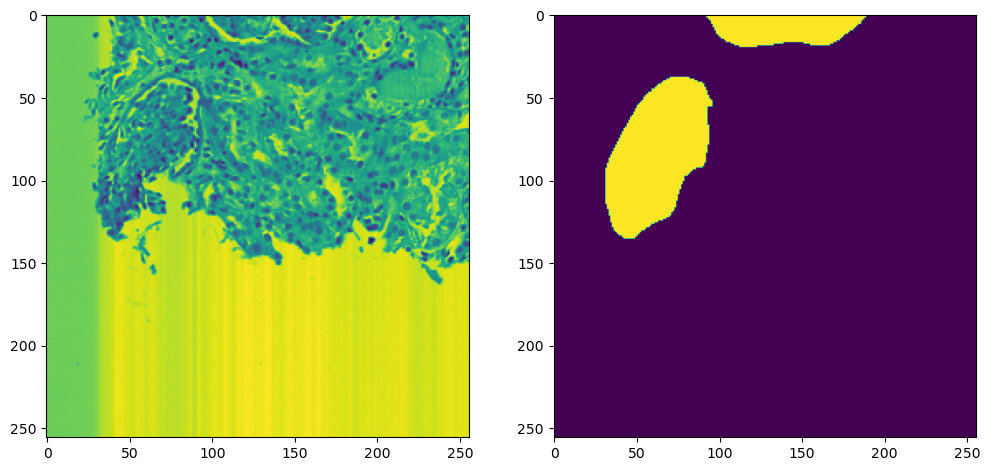

In [26]:

#X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state=0)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)))
plt.show()


In [25]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 72)         720       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 72)         288       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 72)         46728     ['batch_normalization[0

In [27]:
history = model.fit(X_train, y_train, batch_size = 8, verbose=1, epochs=10, validation_data=(X_test, y_test), shuffle=False)

model.save('5layerUnet.hdf5')

Epoch 1/10


 6/62 [=>............................] - ETA: 45:25 - loss: 0.1887 - accuracy: 0.8681

KeyboardInterrupt: 

2/2 [==============================] - 3s 1s/step - loss: 0.0043 - accuracy: 0.9001
Accuracy =  90.01451134681702 %


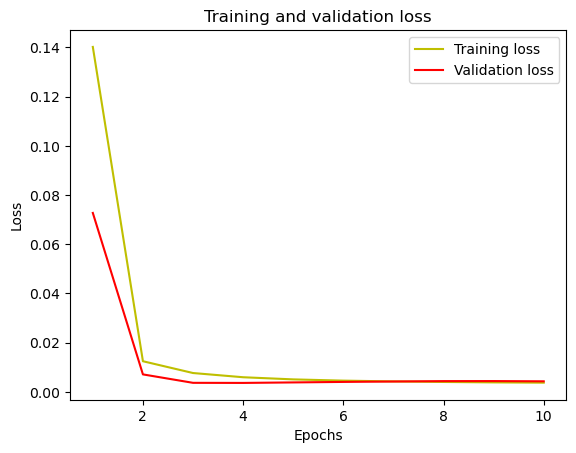

In [60]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

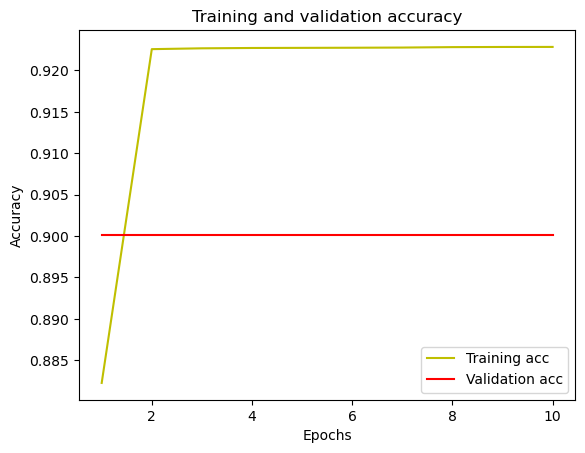

In [61]:
#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [55]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred >=0

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)
#print(intersection.any())

2/2 [==============================] - 3s 1s/step
IoU socre is:  0.09985490278764204


In [70]:
print(precision_score(y_test,y_pred_thresholded, average="macro"))

ValueError: unknown is not supported

In [56]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

In [57]:
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

1/1 [==============================] - 0s 142ms/step


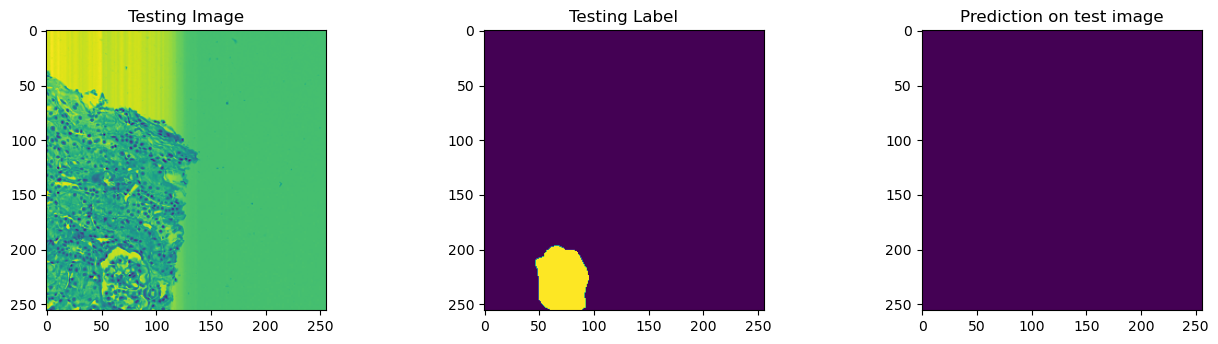

In [58]:


#test_img_other = cv2.imread('1bc.jpge',0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
#test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
#test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
#test_img_other_input=np.expand_dims(test_img_other_norm, 0)

#prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction)
"""plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')"""
plt.show()